# Coolpuppy python API walkthrough notebook

Please see https://github.com/open2c/open2c_examples for detailed explanation of how snipping and pileups work, and explanation of some terminology

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

In [2]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

## Download data

For the test, we collected the data from [immortalized human foreskin fibroblast cell line HFFc6](https://data.4dnucleome.org/ontology-terms/EFO:0009318/):
- Micro-C data from [Krietenstein et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32213324/)
- ChIP-Seq for CTCF from [ENCODE ENCSR000DWQ](https://www.encodeproject.org/experiments/ENCSR000DWQ/)

You can automatically download test datasets with cooltools. More information on the files and how they were obtained is available from the datasets description. 


In [4]:
# Print available datasets for download
cooltools.print_available_datasets()

1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
	Downloaded from https://osf.io/3h9js/download 
	Stored as test.mcool 
	Original md5sum: e4a0fc25c8dc3d38e9065fd74c565dd1

2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
	Downloaded from https://osf.io/w92u3/download 
	Stored as test_CTCF.bigWig 
	Original md5sum: 62429de974b5b4a379578cc85adc65a3

3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
	Downloaded from https://osf.io/c9pwe/download 
	Stored as test_CTCF.bed.gz 
	Original md5sum: 61ecfdfa821571a8e0ea362e8fd48f63



In [5]:
# Downloading test data for pileups
# cache = True will download the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')
ctcf_fc_file = cooltools.download_data("HFF_CTCF_fc", cache=True, data_dir='./')

In [6]:
resolution = 10000
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'{cool_file}::/resolutions/{resolution}')

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.make_viewframe(hg38_arms)

In [8]:
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


In [9]:
hg38_arms.to_csv('hg38_arms.bed', sep='\t', header=False, index=False) # To use in CLI

In [10]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf['mid'] = (ctcf.end+ctcf.start)//2
ctcf.head()

,chrom,start,end,name,score,strand,mid
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-,118494
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+,144011
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-,163685
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+,164720
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-,309425


In [11]:
import bbi

In [12]:
# Get CTCF ChIP-Seq fold-change over input for genomic regions centered at the positions of the motifs

flank = 250 # Length of flank to one side from the boundary, in basepairs
ctcf_chip_signal = bbi.stackup(
    ctcf_fc_file, 
    ctcf.chrom, 
    ctcf.mid-flank, 
    ctcf.mid+flank, 
    bins=1)

ctcf['FC_score'] = ctcf_chip_signal

In [13]:
ctcf['quartile_score']    = pd.qcut(ctcf['score'], 4, labels=False) + 1
ctcf['quartile_FC_score'] = pd.qcut(ctcf['FC_score'], 4, labels=False) + 1
ctcf['peaks_importance'] = ctcf.apply(
    lambda x: 'Top by both scores' if x.quartile_score==4 and x.quartile_FC_score==4 else
                'Top by Motif score' if x.quartile_score==4 else
                'Top by FC score' if x.quartile_FC_score==4 else 'Ordinary peaks', axis=1
)

In [14]:
# Select the CTCF sites that are in top quartile by both the ChIP-Seq data and motif score

sites = ctcf[ctcf['peaks_importance']=='Top by both scores']\
    .sort_values('FC_score', ascending=False)\
    .reset_index(drop=True)
sites.tail()

,chrom,start,end,name,score,strand,mid,FC_score,quartile_score,quartile_FC_score,peaks_importance
659,chr17,8158938,8158957,MA0139.1_CTCF_human,13.276979,-,8158947,25.056849,4,4,Top by both scores
660,chr2,176127201,176127220,MA0139.1_CTCF_human,12.820343,+,176127210,25.027294,4,4,Top by both scores
661,chr17,38322364,38322383,MA0139.1_CTCF_human,13.534864,-,38322373,25.010430,4,4,Top by both scores
662,chr2,119265336,119265355,MA0139.1_CTCF_human,13.739862,-,119265345,24.980141,4,4,Top by both scores
663,chr2,118003514,118003533,MA0139.1_CTCF_human,12.646685,-,118003523,24.957502,4,4,Top by both scores


In [15]:
sites.to_csv('annotated_ctcf_sites.tsv', sep='\t', index=False, header=False) # Let's save to use in CLI

## On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. Coolpuppy will aggregate all snippets around each motif with the specified normalization.

In [16]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms, local=True,
                        flank=300_000, min_diag=0)

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


This is the general format of output of coolpuppy pileup functions: a pandas dataframe with columns "data" and "n" - "data" contains pileups as numpy arrays, and "n" - number of snippets used to generate this pileup.

Different kinds of pileups calculated in one run are stored as rows, and their groups are annotated in the columns preceding "data". Since here we didn't split the data into any groups, there is only one pileup with group "all"

In [17]:
pup

,group,data,n,num,clr,resolution,flank,rescale_flank,chroms,minshift,...,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,nproc
0,all,"[[1.846348485849592, 0.3014234977437898, 0.055...",663,"[[632, 631, 631, 628, 628, 626, 626, 628, 627,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,False,0,False,1


Let's visualize the average Hi-C map at all strong CTCF sites:

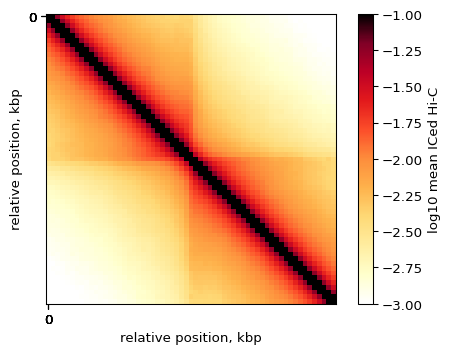

In [18]:
plt.imshow(
    np.log10(pup.loc[0, 'data']),
    vmax = -1,
    vmin = -3.0,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')

plt.show()

## By-strand pileups

Now, we know that orientation of the CTCF site is very important for the interactions it forms. Using coolpuppy, splitting regions by the strand is trivial, expecially using a convenience function:

In [19]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms, local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0)

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


In [20]:
pup

,orientation,strand2,strand1,data,n,num,clr,resolution,flank,rescale_flank,...,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,nproc
0,--,-,-,"[[1.8388677780141118, 0.3035714543313729, 0.05...",326,"[[307, 307, 307, 306, 306, 306, 306, 307, 307,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,...,True,False,30,False,False,99,False,0,False,1
1,++,+,+,"[[1.8534148775587997, 0.2993882425820983, 0.05...",337,"[[325, 324, 324, 322, 322, 320, 320, 321, 320,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,...,True,False,30,False,False,99,False,0,False,1
2,all,all,all,"[[1.846348485849592, 0.30142349774378974, 0.05...",663,"[[632.0, 631.0, 631.0, 628.0, 628.0, 626.0, 62...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,...,True,False,30,False,False,99,False,0,False,1


Now we can use a convenient seaborn-based function from the `plotpup.py` subpackage to create a grid of heatmaps based on by-row and/or by-column variable mapping. In this case, we just map two orientations of CTCF sites across columns.

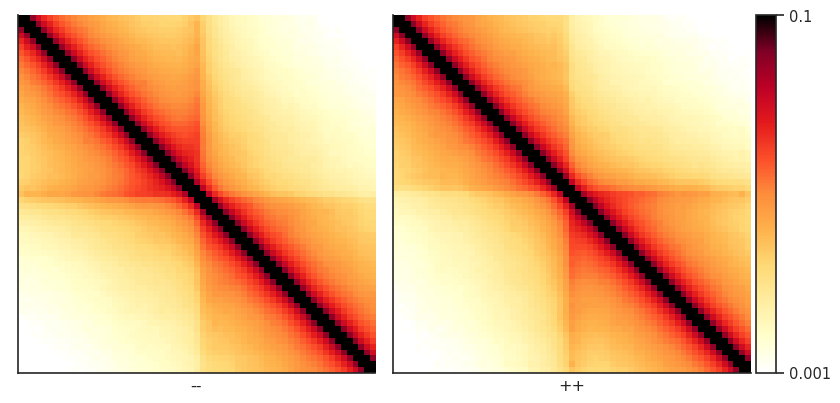

In [21]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.make_heatmap_grid(pup,
                          cols='orientation', col_order=['--', '++'],
                          score=False, cmap='fall', scale='log', sym=False,
                          vmin=0.001, vmax=0.1,
                          height=5)

## Pileups of observed over expected interactions

Sometimes you don't want to include the **distance decay** P(s) in your pileups. For example, when you make comparison of pileups between experiments and they have different P(s). Even if these differences are slight, they might affect the pileup of raw ICed Hi-C interactions. Moreover, without controlling for it the range of values in the pileup is not very easy to guess before plotting.

In this case, the observed over expected pileup is your choice. To normalize your pileup to the background level of interactions, you can either, prior to running the pileup function, calculate expected interactions for each chromosome arms, or you can generate randomly shifted control regions for each snippet, and divide the final pileup by that control pileup.

Let's first try the latter. This analysis is particulalry useful for single-cell Hi-C where the data might be too sparse to generate robust per-diagonal expected values.


In [22]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms, local=True,
                        by_strand=True, nshifts=10,
                        flank=300_000, min_diag=0)

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


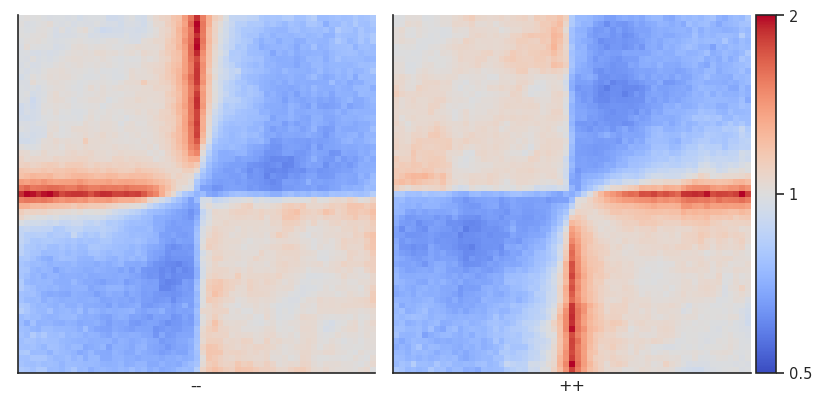

In [23]:
plotpup.make_heatmap_grid(pup,
                         cols='orientation', col_order=['--', '++'],
                         score=False, cmap='coolwarm', scale='log', sym=True,
                         vmax=2,
                         height=5)

As you can see, this strongly highlights the depletion of interactions across the CTCF sites, and enrichment of interactions in a stripe starting from the site.

Now let's calculate per-diagonal expected level of interactions to repeat the analysis using that.

In [24]:
# Calculate expected interactions for chromosome arms
expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=hg38_arms,
    chunksize=1000000)
expected.to_csv('test_expected_cis.tsv', sep='\t', index=False, header=True) # Let's save to use in CLI

In [25]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms, local=True,
                        expected_df=expected, by_strand=True,
                        flank=300_000, min_diag=0)

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


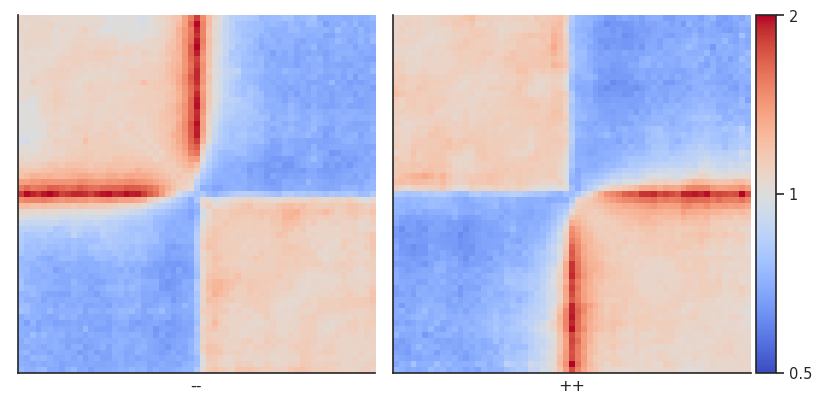

In [26]:
plotpup.make_heatmap_grid(pup,
                          cols='orientation', col_order=['--', '++'],
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

The result is almost identical!

Instead of splitting two strands into two separate pileups, one can also flip the features on the negative strand. This way a single pileup is created where all features face in the same direction (as if they were on the positive strand). We can also add `plot_ticks=True` to show the central and flanking coordinates on the bottom of the plot.

In [27]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms, local=True,
                        expected_df=expected, flip_negative_strand=True,
                        flank=300_000, min_diag=0)

INFO:root:('chr2_p', 'chr2_p'): 144
INFO:root:('chr2_q', 'chr2_q'): 202
INFO:root:('chr17_p', 'chr17_p'): 78
INFO:root:('chr17_q', 'chr17_q'): 239
INFO:root:Total number of piled up windows: 663


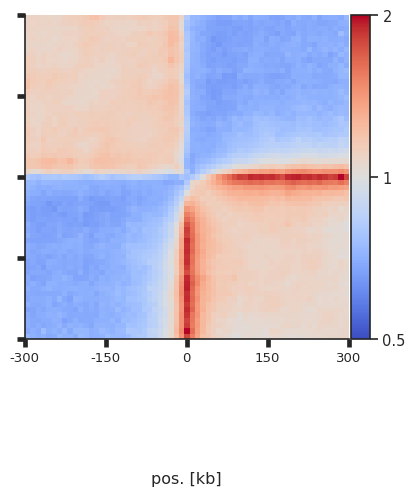

In [28]:
plotpup.make_heatmap_grid(pup,
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5, plot_ticks=True)

## Arbitrary grouping of snippets for pileups

Now, let's see how our selection of only top CTCF peaks affects the results. We could simply repeat the analysis with the rest of CTCF peaks, but to showcase the power of coolpuppy, we'll demonstrate how it can be used to generate pileups split be arbitrary categories

In [29]:
pup, _ = coolpup.pileup(clr, ctcf, features_format='bed', view_df=hg38_arms, local=True,
                        expected_df=expected, flip_negative_strand=True,
                        groupby=['peaks_importance1'],
                        flank=300_000, min_diag=0)
# Splitting all snippets into groups based on annotated previously importance of the peaks
# Also flipping negative stranded features as shown above.

INFO:root:('chr2_p', 'chr2_p'): 1381
INFO:root:('chr2_q', 'chr2_q'): 2221
INFO:root:('chr17_p', 'chr17_p'): 548
INFO:root:('chr17_q', 'chr17_q'): 1602
INFO:root:Total number of piled up windows: 5752


In [30]:
pup

,peaks_importance1,data,n,num,clr,resolution,flank,rescale_flank,chroms,minshift,...,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,nproc
0,Ordinary peaks,"[[1.0699452226771298, 1.0642211188669746, 1.07...",3536,"[[3432, 3421, 3412, 3413, 3403, 3404, 3402, 33...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,True,0,False,1
1,Top by FC score,"[[1.0829924317033595, 1.1009490059442415, 1.09...",778,"[[745, 740, 741, 739, 739, 737, 739, 736, 734,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,True,0,False,1
2,Top by Motif score,"[[1.0288083600349012, 1.0363397675639456, 1.03...",775,"[[750, 749, 746, 744, 746, 741, 743, 743, 739,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,True,0,False,1
3,Top by both scores,"[[1.0773804769093807, 1.0932965447911036, 1.09...",663,"[[640, 638, 638, 635, 634, 632, 631, 630, 629,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,True,0,False,1
4,all,"[[1.067003977204076, 1.0686994220484458, 1.072...",5752,"[[5567.0, 5548.0, 5537.0, 5531.0, 5522.0, 5514...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,300000,None,"['chr2', 'chr17']",100000,...,True,False,30,False,False,99,True,0,False,1


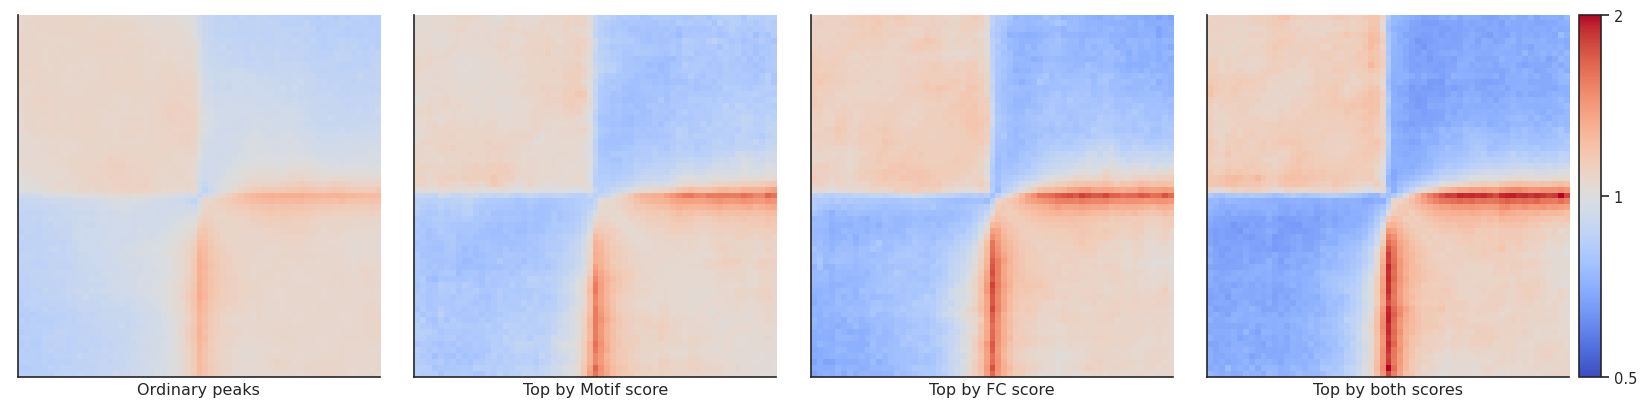

In [31]:
fg = plotpup.make_heatmap_grid(pup.reset_index(), # Simply resetting the idnex makes the output directly compatible with the plotting function - 
                                                        # just need to remember there is also a group "all" which you might not want to show
                               cols='peaks_importance1',
                               col_order=['Ordinary peaks', 'Top by Motif score',
                                          'Top by FC score', 'Top by both scores'],
                               score=False, cmap='coolwarm',
                               scale='log', sym=True, vmax=2,
                               height=5)

## By-distance pileups

As it is known, CTCF sites frequently have peaks of Hi-C interactions between them, that indicate chromatin loops. Let's see at what distances they tend to occur, and let's see what patterns these regions form at different distance separations and different motif orientations.

Since we generate many more snippets than for local (on-diagonal) pileups, it will take a little longer to run. We can use the `nproc` argument to use multiprocessing and run it in parallel to speed it up a bit. Note that parallelization requires more RAM, so use with caution.

In [32]:
# Using all strong sites here to make it faster
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms,
                        expected_df=expected, flip_negative_strand=True,
                        by_distance=True, by_strand=True, mindist=100_000,
                        flank=300_000, min_diag=0,
                        nproc=2
                        )
# Splitting all snippets into groups based on strand and separation between two sites

INFO:root:('chr2_p', 'chr2_p'): 10250
INFO:root:('chr17_p', 'chr17_p'): 2959
INFO:root:('chr2_q', 'chr2_q'): 20215
INFO:root:('chr17_q', 'chr17_q'): 28284
INFO:root:Total number of piled up windows: 61708


In [33]:
pup

,separation,orientation,distance_band,strand2,strand1,data,n,num,clr,resolution,...,ooe,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,nproc
0,0.1Mb-\n0.2Mb,++,"(100000, 200000)",+,+,"[[1.0169219164613472, 0.9600852237815437, 1.01...",67,"[[64, 66, 66, 65, 66, 65, 63, 65, 65, 65, 65, ...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
1,0.2Mb-\n0.4Mb,++,"(200000, 400000)",+,+,"[[0.8621663934782983, 0.8441139544987121, 0.85...",131,"[[125, 126, 126, 126, 126, 126, 125, 126, 126,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
2,0.4Mb-\n0.8Mb,++,"(400000, 800000)",+,+,"[[0.6943248290614478, 0.6951043361705603, 0.68...",245,"[[236, 236, 236, 236, 236, 236, 236, 236, 236,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
3,0.8Mb-\n1.6Mb,++,"(800000, 1600000)",+,+,"[[0.6474314279066417, 0.6349530137034375, 0.68...",425,"[[390, 390, 390, 390, 394, 389, 389, 393, 393,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
4,1.6Mb-\n3.2Mb,++,"(1600000, 3200000)",+,+,"[[0.8110724673135341, 0.8450568161843092, 0.79...",789,"[[727, 727, 727, 727, 732, 727, 718, 736, 734,...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
5,3.2Mb-\n6.4Mb,++,"(3200000, 6400000)",+,+,"[[1.0177356156951203, 1.0096186573824688, 0.97...",1337,"[[1231, 1233, 1233, 1229, 1231, 1228, 1215, 12...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
6,6.4Mb-\n12.8Mb,++,"(6400000, 12800000)",+,+,"[[1.0341610054262953, 1.0598415100413474, 1.04...",2011,"[[1827, 1834, 1834, 1820, 1827, 1813, 1807, 18...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
7,12.8Mb-\n25.6Mb,++,"(12800000, 25600000)",+,+,"[[1.0342172958371685, 0.99230470122746, 0.9868...",3176,"[[3007, 3010, 3010, 3006, 3016, 3003, 2987, 30...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
8,25.6Mb-\n51.2Mb,++,"(25600000, 51200000)",+,+,"[[1.0952479689725, 1.1274658205079064, 1.19044...",4007,"[[3810, 3810, 3810, 3810, 3810, 3810, 3810, 38...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2
9,51.2Mb-\n102.4Mb,++,"(51200000, 102400000)",+,+,"[[1.0403519065237432, 1.0428039807320282, 0.99...",2212,"[[2103, 2103, 2103, 2103, 2103, 2103, 2103, 21...",/Users/ilya/Projects/coolpuppy/docs/source/Exa...,10000,...,True,False,30,False,False,99,True,0,False,2


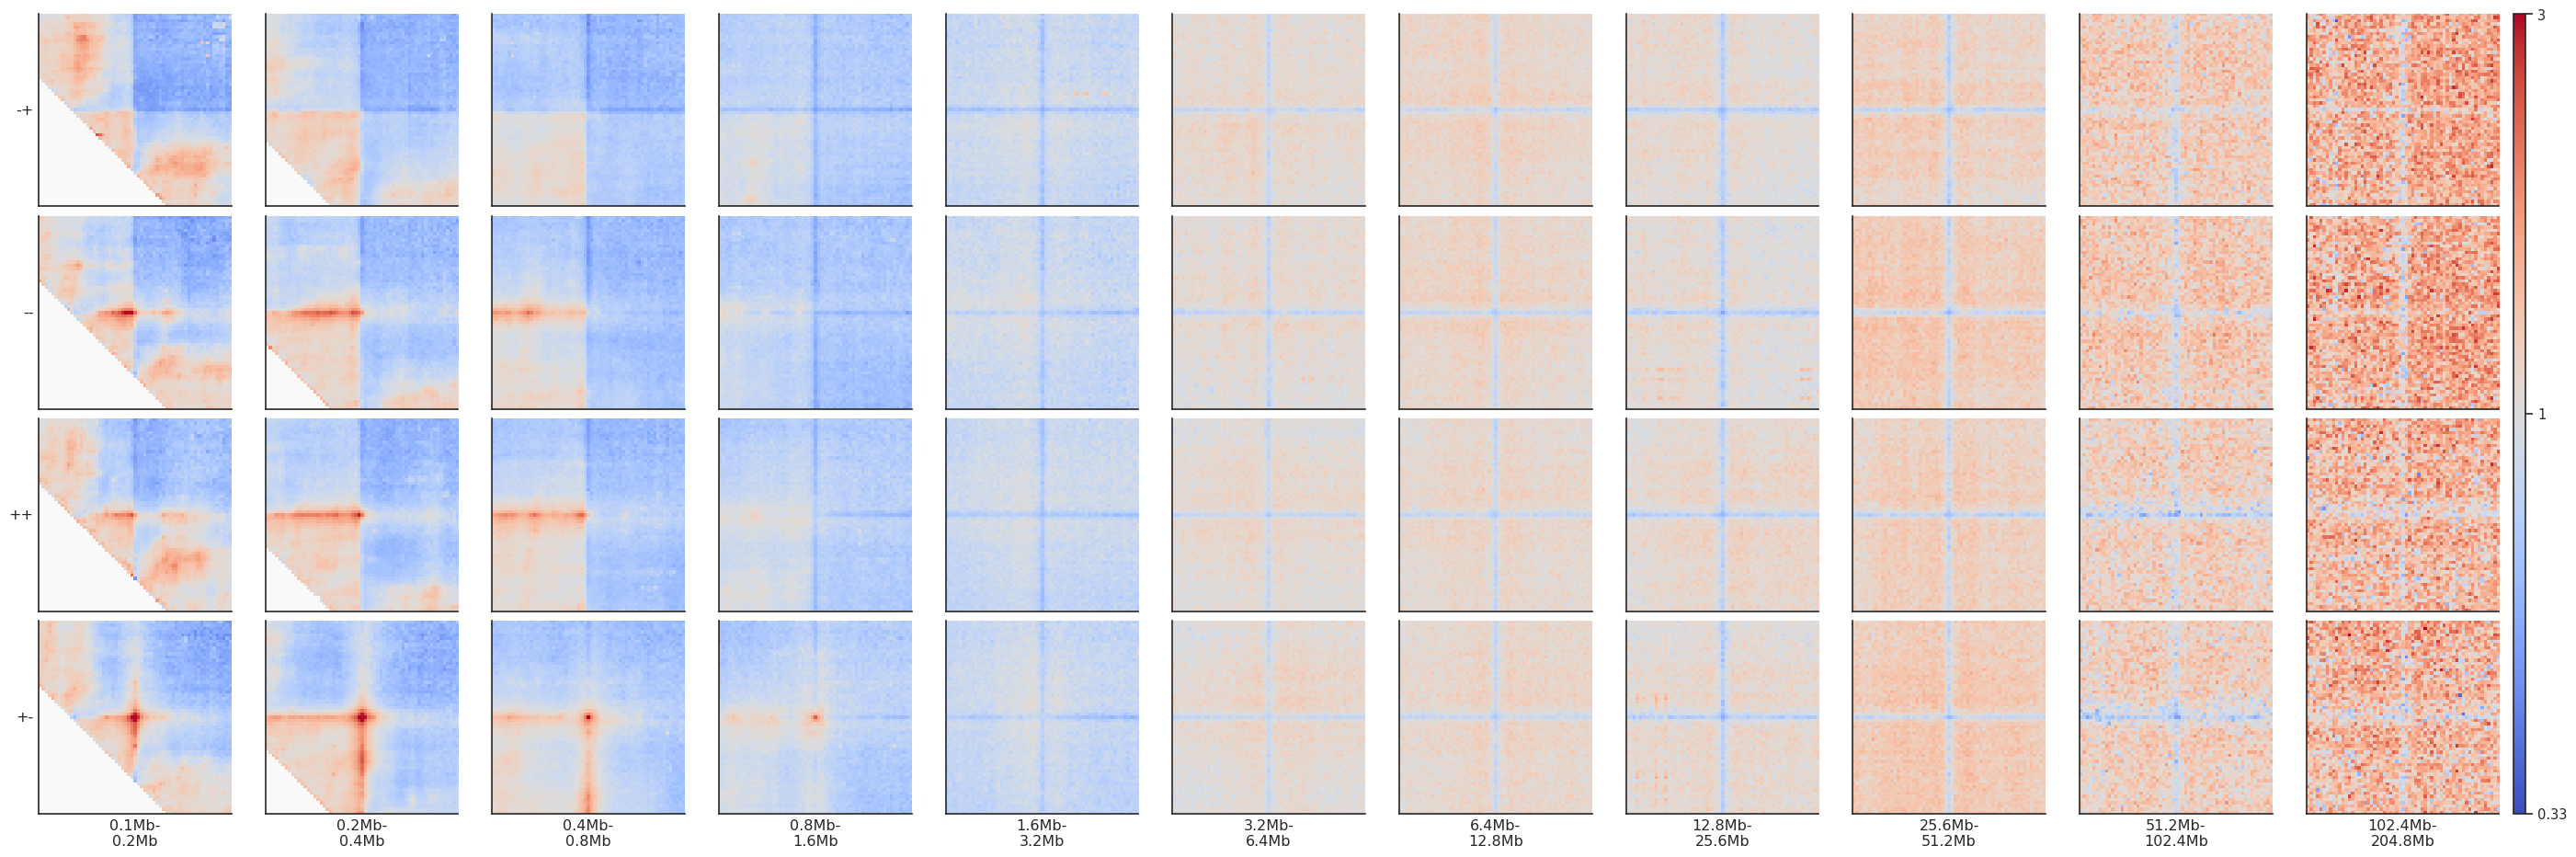

In [34]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               score=False, cmap='coolwarm', scale='log', sym=True, vmax=3,
                               height=3)

Note that since CTCF sites are preferentially found in the A compartment, the expected level of interactions at different distances varies, generating different background interaction levels. We can artificially fix that by normalizing each pileup by the average interactions in the top-left and bottom-right corners.

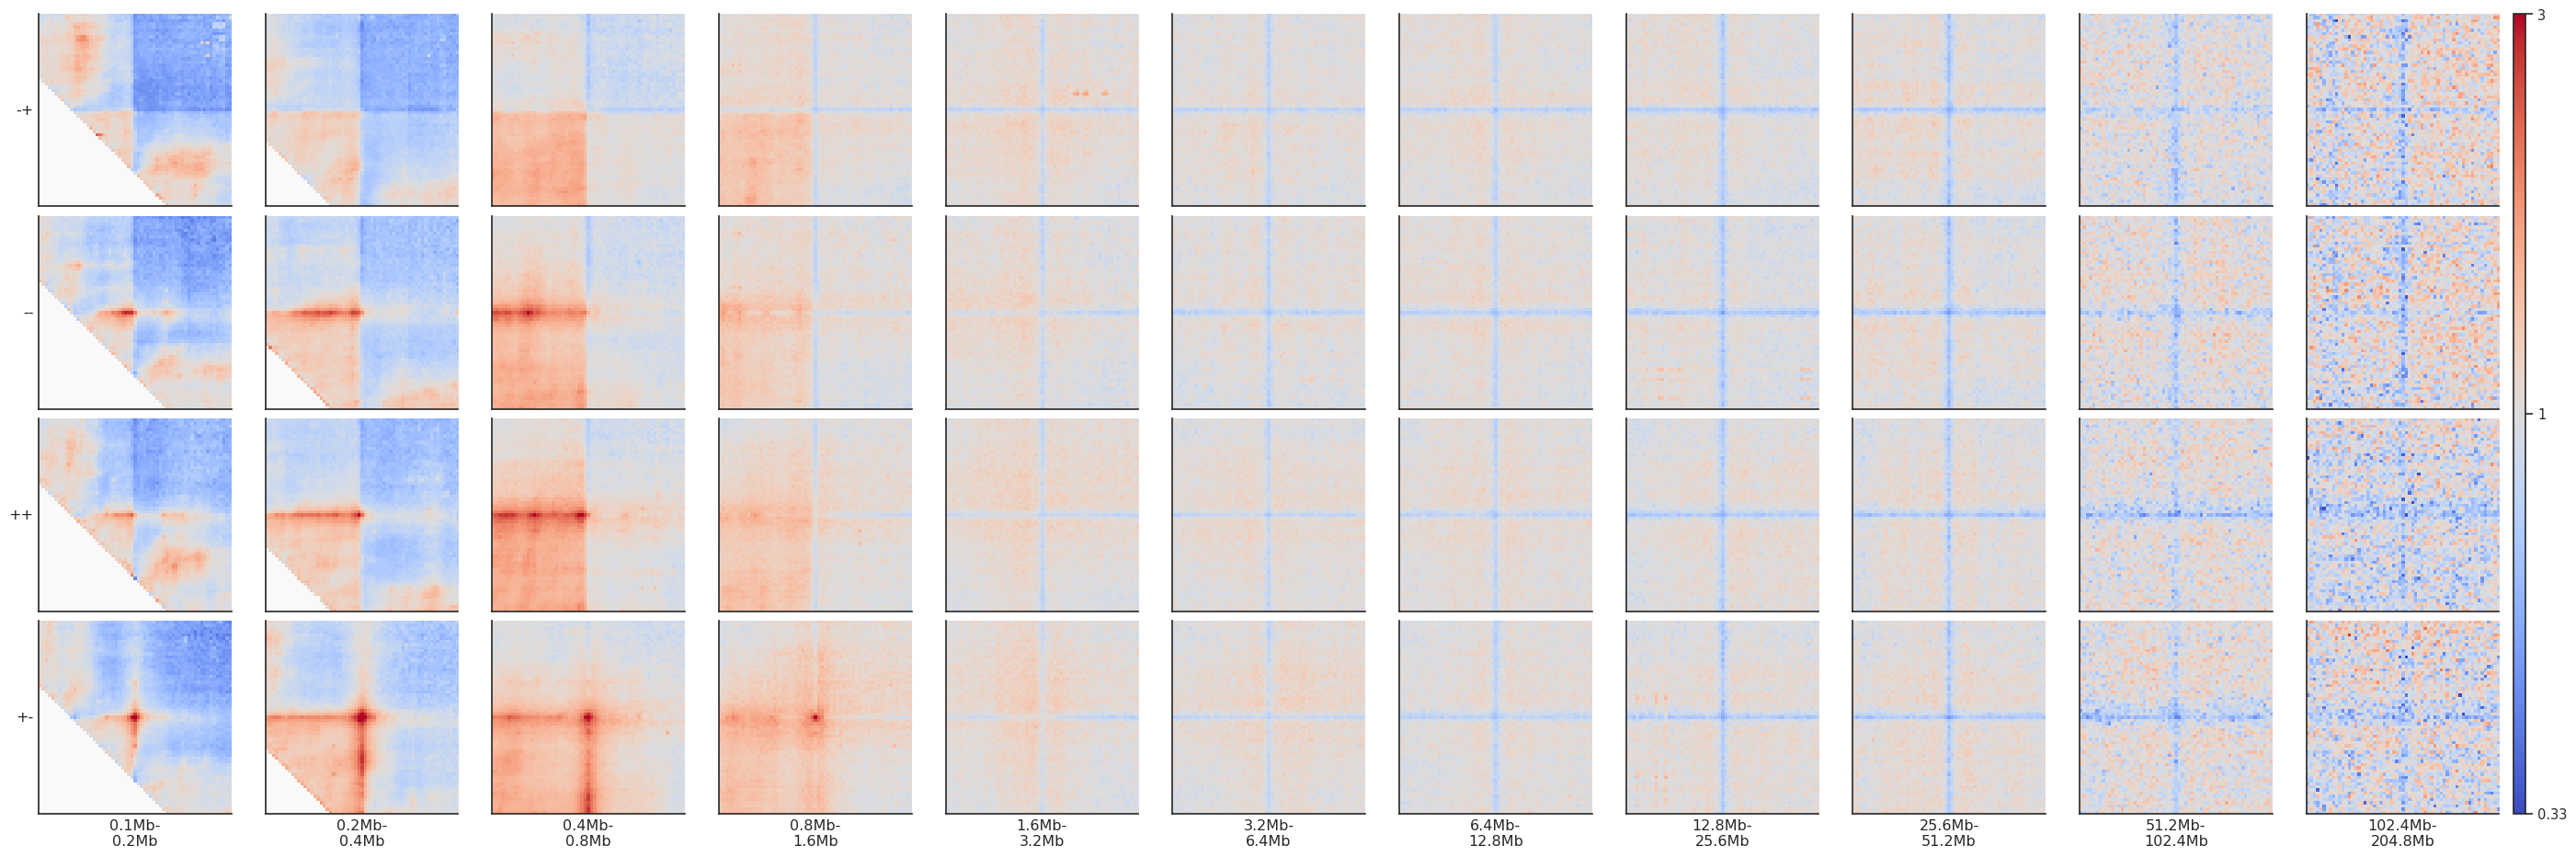

In [35]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               score=False, cmap='coolwarm', scale='log', sym=True, vmax=3,
                               norm_corners=10,
                               height=3)

If you want to actually modify the data in your dataframe to normalize to the corners and not just apply it for vizualisation, you can do that explicitly:

In [36]:
pup['data'] = pup['data'].apply(numutils.norm_cis, i=10)

A good idea to give some more quantitative information about the level of enrichment of interactions in the center of the pileup is to just label the average value of the few central pixels of the heatmap. The simplest way is to use the argument `score`:

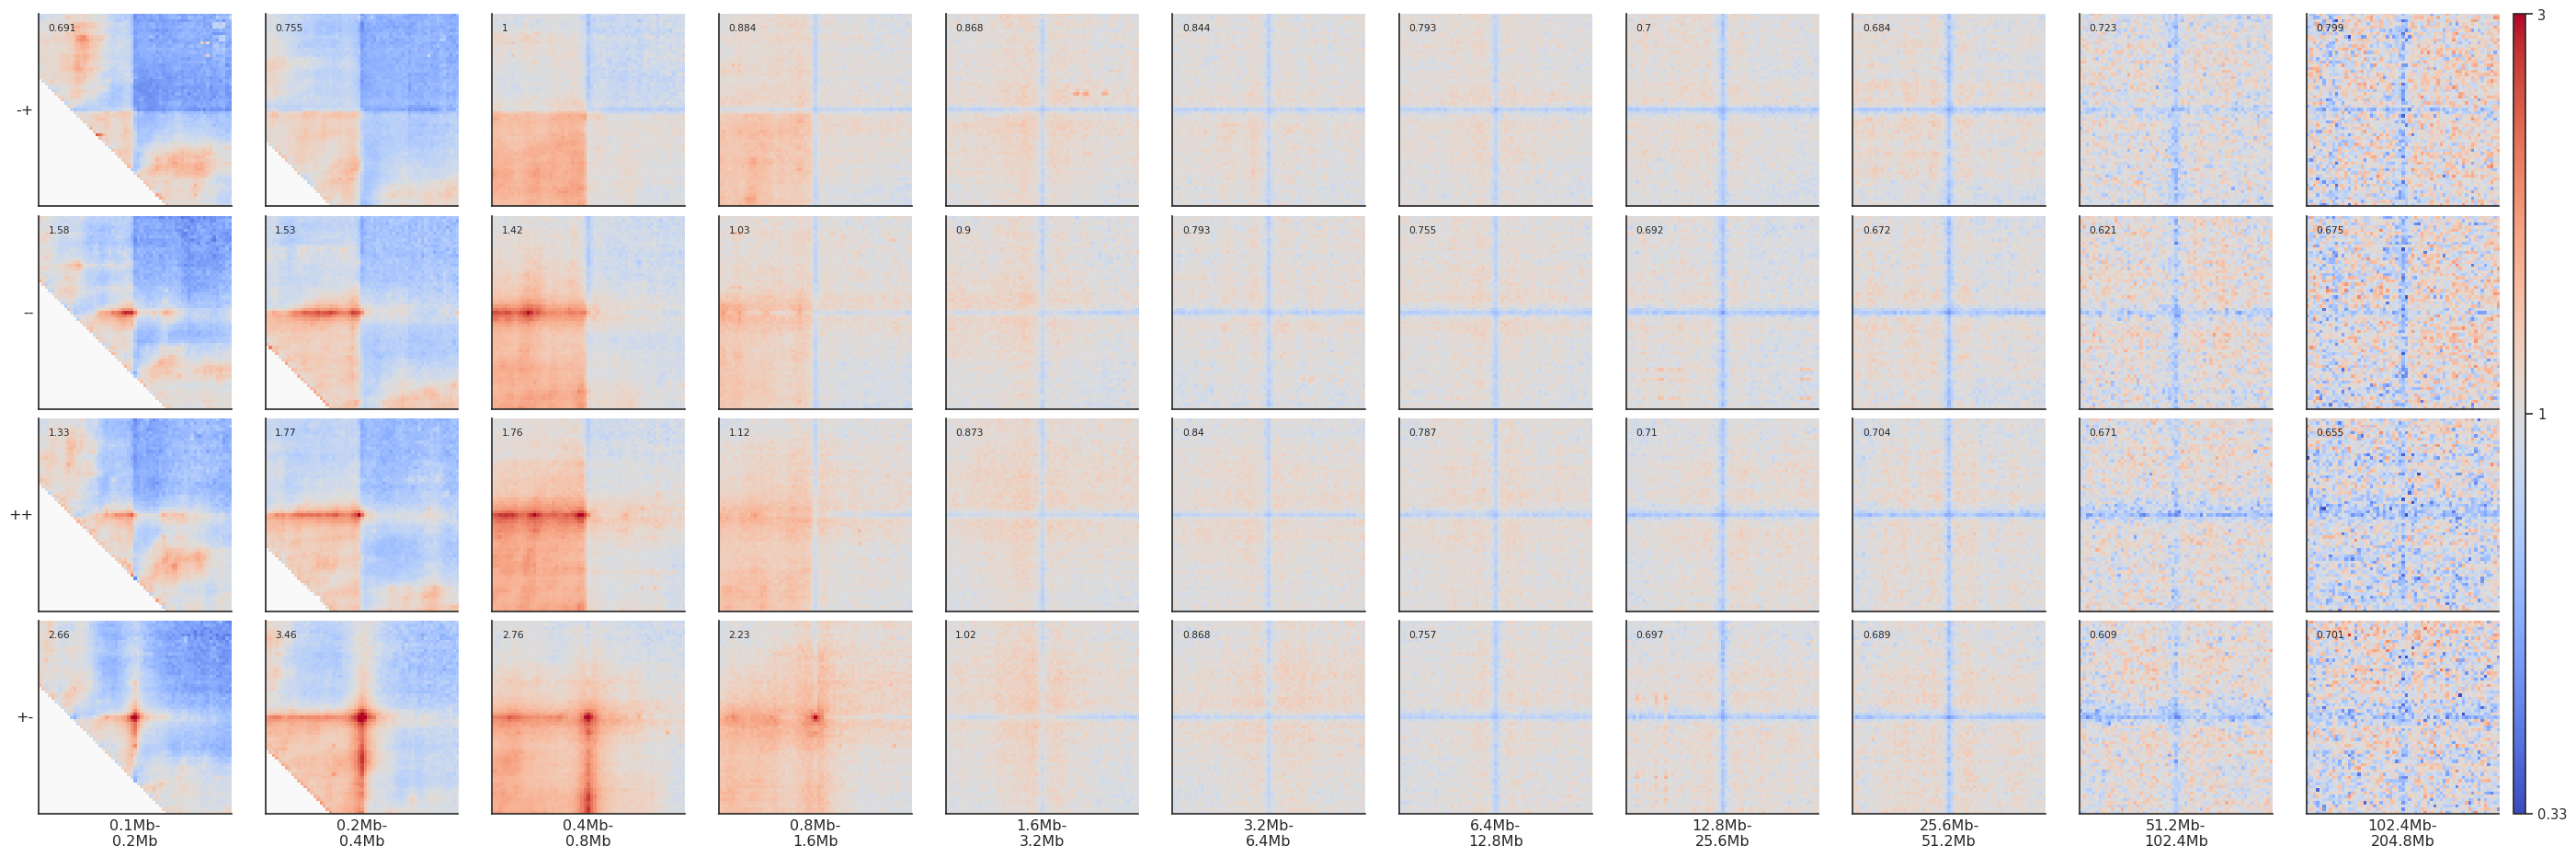

In [37]:
fg = plotpup.make_heatmap_grid(pup, rows='orientation', cols='separation',
                               row_order=['-+', '--', '++', '+-'],
                               score=True,
                               cmap='coolwarm', scale='log', sym=True, vmax=3,
                               height=3)

## Dividing pileups

Sometimes you may want to compare two pileups directly and plot the result of the division between them. For this we can use the `divide_pups` function. Let's look at all CTCF interactions between 100 kb and 1 Mb by motif orientation.


In [38]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms,
                        expected_df=expected,
                        by_strand=True, mindist=100_000, maxdist=1_000_000,
                        flank=300_000, nproc=2)

INFO:root:('chr2_p', 'chr2_p'): 287
INFO:root:('chr2_q', 'chr2_q'): 522
INFO:root:('chr17_p', 'chr17_p'): 262
INFO:root:('chr17_q', 'chr17_q'): 1235
INFO:root:Total number of piled up windows: 2306


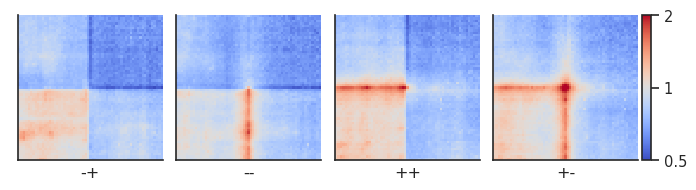

In [39]:
plotpup.make_heatmap_grid(pup,
                          cols="orientation",
                          col_order=["-+", "--", "++", "+-"],
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=2)

Let's compare the ++ to the -- CTCF motif orientation pileups. First, we have to create two separate pileup dataframes from the strand-separated pileups. Alternatively, you could generate two new pileups and store them. Importantly, the two pileups cannot differ with regards to the columns they contain and the resolution, flank size etc. they've been generated using.

In [40]:
pup_plus = pup.loc[pup["orientation"]=="++"].drop(columns=["strand1", "strand2", "orientation"])
pup_minus = pup.loc[pup["orientation"]=="--"].drop(columns=["strand1", "strand2", "orientation"])

In [41]:
pup_divide = divide_pups(pup_plus, pup_minus)

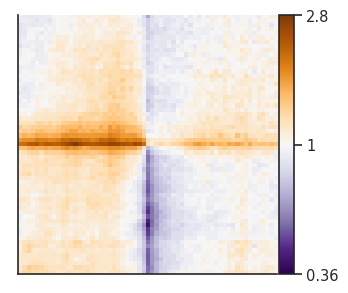

In [42]:
plotpup.make_heatmap_grid(pup_divide,
                          score=False, cmap='PuOr_r', scale='log',
                          sym=True, height=4)

## Stripe stackups

Oftentimes, as seen in the examples above, the interactions between regions are not just focal, but seen as stripes with enrichment along the vertical/horizontal axis from one or both of the anchor points. In the CTCF pileups from above we see a very strong corner stripe between +- sites, so let's try to plot these individual stripes. Below is a schematic of what is meant by the different types of stripes.

![Stripes](./stripes.png)

We first have store this information when generating the pileup using the `store_stripes=True` argument which will add the columns `corner_stripe`, `vertical_stripe`, and `horizontal_stripe` to the output.

In [43]:
pup, _ = coolpup.pileup(clr, sites, features_format='bed', view_df=hg38_arms,
                        expected_df=expected,
                        by_strand=True, mindist=100_000, maxdist=1_000_000,
                        flank=300_000, nproc=2,
                        store_stripes=True)

INFO:root:('chr2_p', 'chr2_p'): 287
INFO:root:('chr2_q', 'chr2_q'): 522
INFO:root:('chr17_p', 'chr17_p'): 262
INFO:root:('chr17_q', 'chr17_q'): 1235
INFO:root:Total number of piled up windows: 2306


We can plot the stripes using the the `make_heatmap_stripes` function

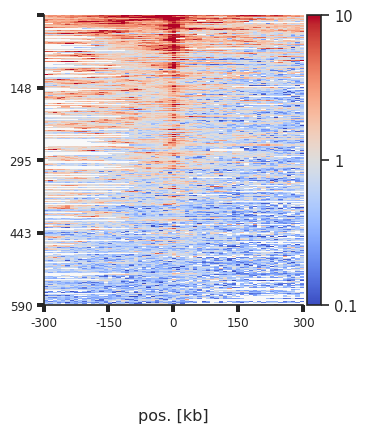

In [44]:
sns.set(font_scale = 1.3, style="ticks")
plotpup.make_heatmap_stripes(pup.loc[(pup["strand1"] == "+") &
                                     (pup["strand2"] == "-"),:],
                             vmax=10, height=4, 
                             stripe="corner_stripe", plot_ticks=True)

Each line of the above plot represents the "corner stripe" between two regions. These pairs are sorted by the sum of the stripe by default, but we can also sort them by the central pixel, i.e. the pixel where the two regions of interest interact, with the `stripe_sort` argument. We can further save the pairs in the sorted order using `out_sorted_bedpe`. This file can then be used to inspect individual pairs with high contact frequencies.

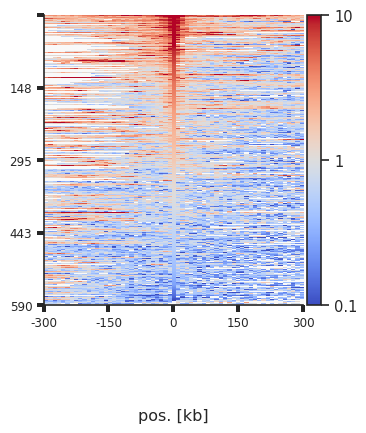

In [45]:
plotpup.make_heatmap_stripes(pup.loc[(pup["strand1"] == "+") &
                                     (pup["strand2"] == "-"),:],
                             vmax=10, height=4, 
                             stripe="corner_stripe", plot_ticks=True,
                             stripe_sort="center_pixel", 
                             out_sorted_bedpe="CTCF_+-_sorted_centerpixel.bedpe")

## Rescaling

Pileups can also be rescaled to visualise enrichment within regions of interests of different sizes using `rescale=True`. The `rescale_flank` value represents how large the flanks are compared to the region of interest, where 1 is equal in size and for example 3 will be three times the size. The number of pixels in the final plot after rescaling is set with `rescale_size`. Let's try this for B compartment interactions.

In [46]:
# Load cooler at 1 Mb resolution
clr_1Mb = cooler.Cooler(f'{cool_file}::/resolutions/1000000')
# Calculate eigenvectors
cis_eigs = cooltools.eigs_cis(clr_1Mb, n_eigs=3)
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
# Extract B compartments
B_compartments = bioframe.merge(eigenvector_track[eigenvector_track["E1"] < 0], min_dist=0)
# Let's save to use it in CLI
B_compartments[["chrom", "start", "end"]].to_csv("B_compartments.bed", sep="\t", header=None, index=False)

In [47]:
pup, _ = coolpup.pileup(clr, B_compartments, features_format='bed', view_df=hg38_arms,
                        expected_df=expected,
                        rescale=True, rescale_flank=1, rescale_size=99,
                        flank=300_000, nproc=2)

INFO:root:Rescaling with rescale_flank = 1 to 99x99 pixels
INFO:root:('chr2_p', 'chr2_p'): 36
INFO:root:('chr17_p', 'chr17_p'): 6
INFO:root:('chr17_q', 'chr17_q'): 21
INFO:root:('chr2_q', 'chr2_q'): 153
INFO:root:Total number of piled up windows: 216


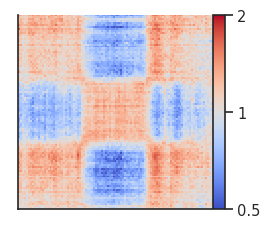

In [48]:
fg = plotpup.make_heatmap_grid(pup,
                               score=False, cmap='coolwarm', scale='log', 
                               sym=True, vmax=2, height=3)

## Trans (inter-chromosomal) pileups

We can also perform pileups between regions on different chromosomes. We will try this for insulation score boundaries (TAD boundaries), first for cis (within chromosomes) and then for trans (between chromosomes). 

In [49]:
# Call insulation score at windows of 50 kb
insulation_table = cooltools.insulation(clr, [50000], verbose=True)
# Select strong boundaries
strong_boundaries = insulation_table.loc[insulation_table["boundary_strength_50000"] > 1.5, :]
# Let's save to use it in CLI
strong_boundaries[["chrom", "start", "end"]].to_csv("strong_boundaries.bed", sep="\t", header=None, index=False)

INFO:root:Processing region chr2
INFO:root:Processing region chr17


In [50]:
pup, _ = coolpup.pileup(clr, strong_boundaries, features_format='bed', view_df=hg38_arms,
                        expected_df=expected,
                        flank=300_000, nproc=2)

INFO:root:('chr2_p', 'chr2_p'): 807
INFO:root:('chr17_p', 'chr17_p'): 99
INFO:root:('chr2_q', 'chr2_q'): 2262
INFO:root:('chr17_q', 'chr17_q'): 1354
INFO:root:Total number of piled up windows: 4522


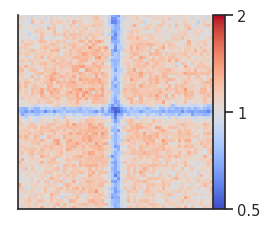

In [51]:
plotpup.make_heatmap_grid(pup,
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=3)

Here we can see the boundary pileups within chromosome arms where interactions are depleted at the boundaries. To perform the same analysis between chromosomes, we first need to generate a new expected file (or use shifted controls) and then run the analysis with `trans=True`.

In [52]:
# Calculate expected interactions between chromosomes
trans_expected = expected_trans(
    clr, 
    chunksize=1000000)

In [53]:
trans_expected

,region1,region2,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr2,chr17,169848938,1303548.0,206.059958,0.007675,0.000001


In [54]:
pup, _ = coolpup.pileup(clr, strong_boundaries, features_format='bed',
                        expected_df=trans_expected,
                        trans=True,
                        flank=300_000, nproc=2)

/Users/ilya/Projects/coolpuppy/coolpuppy/coolpup.py:1969: UserWarning: Ignoring maxdist when using trans
  CC = CoordCreator(
INFO:root:('chr2', 'chr17'): 7412
INFO:root:Total number of piled up windows: 7412


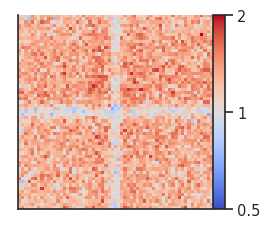

In [55]:
plotpup.make_heatmap_grid(pup,
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=3)

Here we can see that boundaries are depleted in interactions also between chromosomes.